In [2]:
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt

# Process data

In [3]:
IMAGE_SIZE = (28, 28)
EPOCH = 1000
LEARNING_RATE = 0.00001

# Import data
data = pd.read_csv(r"../digit-recognizer/train.csv")
data_test = pd.read_csv(r"../digit-recognizer/test.csv")    

# Get labels and image array from data
labels : np.ndarray = data.values[:, 0]
images : np.ndarray = data.values[:, 1:].astype('uint8')

images_test : np.ndarray = data_test.values.astype('uint8')

# Reference for backpropagation (from 3b1b neural network video)

![title](image.png)

# <center> MODELS </center>

In [18]:
class Model:
    def __init__(self, input, hidden, output, lr):
        # Initialize weight and bias
        self.w_input = np.random.normal(size=(input, hidden))
        self.b_input = np.zeros(hidden)
        self.w_hidden = np.random.normal(size=(hidden, output))
        self.b_hidden = np.zeros(output)
        
        self.lr = lr
        self.costs = []

    def _sigmoid(self, x, derive=False):
        if derive:
            return self._sigmoid(x) * (1-self._sigmoid(x))
        return 1 / (1 + np.exp(-x))

    def _softmax(self, x : np.ndarray):
        exps = np.exp(x - x.max())
        return exps / np.sum(exps) 

    def plot(self):
        plt.plot(self.costs, 'bo')
        plt.xlabel("Data")
        plt.ylabel("Costs")
        plt.show()



class Softmax(Model):
    def __init__(self, input, hidden, output, lr):
        super().__init__(input, hidden, output, lr)
    
    def forward(self, x):
        x = np.dot(x, self.w_input)
        # x += self.b_input
        # x = self._sigmoid(x)
        x = np.dot(x, self.w_hidden)
        x = np.clip(x, 1e-7, 1e7)
        # x += self.b_hidden
        x = self._softmax(x)
        
        return x

    def train(self, input: np.ndarray, pred: np.ndarray, label: np.ndarray, debug=False):
        # ============================================
        # Softmax with Cross Entropy Loss
        # cost = -ln(pred[argmax(label)]) {natural log of correct prediction}
        # d_cost/d_pred = -1 / pred[argmax(label)] {1 value}
        
        # pred = softmax(out)
        # d_pred/d_out = {(10, 10) matrix, because all output values affect the softmax value}
        #   i = j ->1``
        
        correct = label.argmax()
        d_pred = []
        for i in range(len(pred)):
            if i == correct:
                d_pred.append(pred[correct] * (1-pred[i]))
            else:
                d_pred.append(-pred[correct] * pred[i])

        d_cost = -1 / pred[correct]
        d_pred = np.array(d_pred)
        d_out = self.w_hidden
        d_hidden = input

        # 1, (10, ) (16, 10) (784, )
        step = np.outer(d_hidden, np.dot(d_out, d_pred)) * d_cost * self.lr
        # print(d_cost, d_pred.shape, d_out.shape, d_hidden.shape)
        self.w_hidden -= np.outer(np.dot(input, self.w_input), d_pred * d_cost) * self.lr
        self.w_input -= step
        
        # Debug
        if (debug):
            print("Cost: ", -np.log(pred[correct]))
            # print("Step: ", step)
             # print("d_pred: ", d_pred)
            # print("d_cost: ", d_cost)
            
        # ============================================



class Sigmoid(Model):
    def __init__(self, input, hidden, output, lr):
        super().__init__(input, hidden, output, lr)

    def forward(self, x):
        x = np.dot(x, self.w_input)
        # x += self.b_input
        x = np.dot(x, self.w_hidden)
        # x += self.b_hidden
        x = self._sigmoid(x)
        
        return x

    def train(self, input: np.ndarray, pred: np.ndarray, label: np.ndarray, debug=False):
        # ============================================
        # # Sigmoid with MSELoss (Mean Squared Error)
        # cost = 1/len(pred) * np.sum(pred-label)**2
        # d_cost/d_pred = 2/len(pred) * (pred-label)
        # d_cost = 10 (1 for each prediction?)
        
        # pred = _sigmoid(out) {a(L)}
        # d_pred/d_out = self._sigmoid(out, derive=True)
        # d_pred = 10 (1 for each output?)     
        
        # out = dot(dot(input, w_input), w_hidden)
        # d_out/d_hidden = w_hidden (how much does hidden layer affects output, which depends on hidden layer's weight)
        # d_out = hidden_size * output_size {(16, 10) matrix}

        # hidden = dot(input, w_input)
        # d_hidden/d_w_input = input (how much does weight affects hidden values, which depends on input)

        # Gradient Descent
        d_cost = 2/len(pred) * (pred-label) # (10, )
        d_pred = self._sigmoid(np.dot(np.dot(input, self.w_input), self.w_hidden), derive=True) # (10, )
        d_out = self.w_hidden # (16, 10)
        d_hidden = input # (784, )

        # print(np.dot(input, self.w_input).shape)
        self.w_hidden -= np.outer(np.dot(input, self.w_input), d_pred * d_cost) * self.lr
        self.w_input -= np.outer(d_hidden, np.dot(d_out, d_pred * d_cost)) * self.lr
        
        self.costs.append(np.sum(pred-label)**2/len(pred))

        # Debug
        if (debug):
            print("Cost: ", np.sum(pred-label)**2/len(pred))
            # print("Step: ", step)
            # print("d_pred: ", d_pred)
            # print("d_cost: ", d_cost)
            
        # ============================================

# Test

Cost:  16.11809565095832
Data 2000: Wrong = 1690, Accuracy: 15.457728864432212%
Cost:  4.8512842749639555e-09
Data 4000: Wrong = 3343, Accuracy: 16.40410102525631%
Cost:  4.440892098500627e-16
Data 6000: Wrong = 5018, Accuracy: 16.352725454242375%
Cost:  16.11809565095832
Data 8000: Wrong = 6672, Accuracy: 16.589573696712094%
Cost:  16.11809565095832
Data 10000: Wrong = 8338, Accuracy: 16.611661166116605%
Cost:  16.11809565095832
Data 12000: Wrong = 9988, Accuracy: 16.759729977498125%
Cost:  0.725840327934003
Data 14000: Wrong = 11609, Accuracy: 17.072648046289018%
Cost:  16.11809565095832
Data 16000: Wrong = 13256, Accuracy: 17.14482155134695%
Cost:  0.15640407425369163
Data 18000: Wrong = 14854, Accuracy: 17.47319295516418%
Cost:  16.11809565095832
Data 20000: Wrong = 16453, Accuracy: 17.73088654432722%
Cost:  16.11809565095832
Data 22000: Wrong = 18065, Accuracy: 17.88263102868312%
Cost:  16.11809565095832
Data 24000: Wrong = 19668, Accuracy: 18.04658527438643%
Cost:  16.11809565095

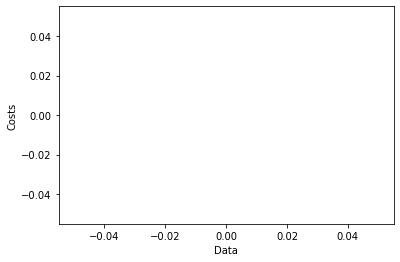

Epoch: 1 --> Wrong: 33671, Accuracy: 19.830952380952382%

Cost:  16.11809565095832
Data 2000: Wrong = 1513, Accuracy: 24.31215607803901%
Cost:  -0.0
Data 4000: Wrong = 2998, Accuracy: 25.03125781445361%
Cost:  0.011178033225924238
Data 6000: Wrong = 4499, Accuracy: 25.004167361226877%
Cost:  16.11809565095832
Data 8000: Wrong = 5967, Accuracy: 25.40317539692461%
Cost:  10.236683855549874
Data 10000: Wrong = 7473, Accuracy: 25.262526252625264%
Cost:  16.11809565095832
Data 12000: Wrong = 8942, Accuracy: 25.477123093591132%
Cost:  7.587852555993923
Data 14000: Wrong = 10402, Accuracy: 25.694692478034142%
Cost:  0.00017503522928671164
Data 16000: Wrong = 11878, Accuracy: 25.757859866241645%
Cost:  0.12439314343447207
Data 18000: Wrong = 13315, Accuracy: 26.02366798155454%
Cost:  2.5677818426009793
Data 20000: Wrong = 14743, Accuracy: 26.281314065703285%
Cost:  3.6960530080301837
Data 22000: Wrong = 16156, Accuracy: 26.56029819537251%
Cost:  16.11809565095832
Data 24000: Wrong = 17554, Acc

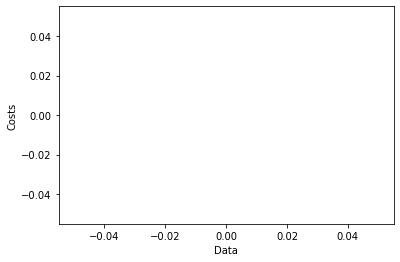

Epoch: 2 --> Wrong: 29882, Accuracy: 28.852380952380955%

Cost:  7.004561904651686
Data 2000: Wrong = 1321, Accuracy: 33.916958479239625%
Cost:  -0.0
Data 4000: Wrong = 2631, Accuracy: 34.208552138034506%
Cost:  1.378693217679873e-05
Data 6000: Wrong = 3952, Accuracy: 34.12235372562094%
Cost:  12.161851642510975
Data 8000: Wrong = 5251, Accuracy: 34.354294286785844%
Cost:  11.334696856602246
Data 10000: Wrong = 6591, Accuracy: 34.08340834083408%
Cost:  16.11809565095832
Data 12000: Wrong = 7868, Accuracy: 34.42786898908243%
Cost:  3.959066803153979
Data 14000: Wrong = 9157, Accuracy: 34.58818487034789%
Cost:  3.1178991767051615e-06
Data 16000: Wrong = 10450, Accuracy: 34.6834177136071%
Cost:  9.289357677770412e-05
Data 18000: Wrong = 11705, Accuracy: 34.96860936718707%
Cost:  0.049871978885885127
Data 20000: Wrong = 12964, Accuracy: 35.176758837941904%
Cost:  0.02953701398902396
Data 22000: Wrong = 14246, Accuracy: 35.24251102322833%
Cost:  8.026078173190877
Data 24000: Wrong = 15475, 

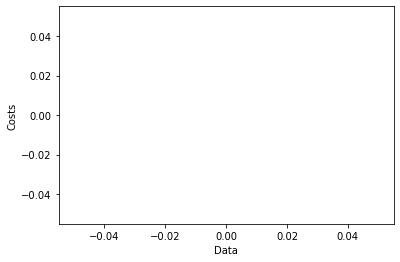

Epoch: 3 --> Wrong: 26232, Accuracy: 37.542857142857144%

Cost:  0.7694430993253618
Data 2000: Wrong = 1142, Accuracy: 42.87143571785893%
Cost:  -0.0
Data 4000: Wrong = 2288, Accuracy: 42.78569642410602%
Cost:  2.4646114377830476e-07
Data 6000: Wrong = 3448, Accuracy: 42.52375395899316%
Cost:  4.072213619237157
Data 8000: Wrong = 4587, Accuracy: 42.65533191648956%
Cost:  11.17428146043039
Data 10000: Wrong = 5743, Accuracy: 42.56425642564257%
Cost:  16.11809565095832
Data 12000: Wrong = 6863, Accuracy: 42.80356696391367%
Cost:  0.5182279520081788
Data 14000: Wrong = 8020, Accuracy: 42.710193585256086%
Cost:  4.1915080708783076e-07
Data 16000: Wrong = 9146, Accuracy: 42.833927120445026%
Cost:  3.1818709022668465e-07
Data 18000: Wrong = 10271, Accuracy: 42.93571865103617%
Cost:  0.0039725204917874755
Data 20000: Wrong = 11404, Accuracy: 42.97714885744287%
Cost:  0.0008048872509396109
Data 22000: Wrong = 12547, Accuracy: 42.965589344970226%
Cost:  1.5621773713936475
Data 24000: Wrong = 13

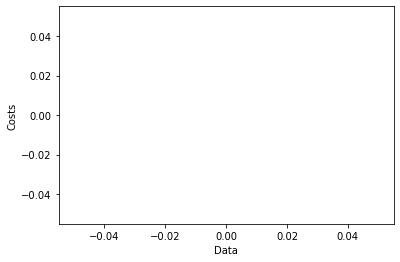

Epoch: 4 --> Wrong: 23206, Accuracy: 44.74761904761905%

Cost:  0.10347027754345504
Data 2000: Wrong = 1027, Accuracy: 48.62431215607804%
Cost:  -0.0
Data 4000: Wrong = 2055, Accuracy: 48.612153038259564%
Cost:  1.8832347525558573e-08
Data 6000: Wrong = 3120, Accuracy: 47.991331888648105%
Cost:  0.06593370509098558
Data 8000: Wrong = 4168, Accuracy: 47.893486685835725%
Cost:  6.313964887847346
Data 10000: Wrong = 5219, Accuracy: 47.8047804780478%
Cost:  16.11809565095832
Data 12000: Wrong = 6233, Accuracy: 48.05400450037504%
Cost:  0.021556420462828928
Data 14000: Wrong = 7281, Accuracy: 47.98914208157725%
Cost:  1.539308518107539e-07
Data 16000: Wrong = 8280, Accuracy: 48.24676542283892%
Cost:  6.155188599990528e-09
Data 18000: Wrong = 9299, Accuracy: 48.33601866770376%
Cost:  0.00014754200382445897
Data 20000: Wrong = 10329, Accuracy: 48.35241762088104%
Cost:  6.809102277078544e-05
Data 22000: Wrong = 11369, Accuracy: 48.32037819900905%
Cost:  0.09997283851312946
Data 24000: Wrong = 

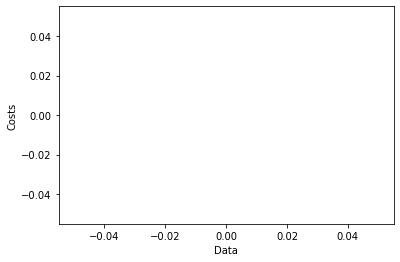

Epoch: 5 --> Wrong: 21101, Accuracy: 49.759523809523806%

Cost:  0.031202094700421425
Data 2000: Wrong = 930, Accuracy: 53.47673836918459%
Cost:  1.1102230246251571e-15
Data 4000: Wrong = 1881, Accuracy: 52.96324081020255%
Cost:  4.199537171281741e-09
Data 6000: Wrong = 2861, Accuracy: 52.30871811968662%
Cost:  0.00043700197593404767
Data 8000: Wrong = 3807, Accuracy: 52.40655081885235%
Cost:  2.353981286059197
Data 10000: Wrong = 4766, Accuracy: 52.335233523352336%
Cost:  16.11809565095832
Data 12000: Wrong = 5696, Accuracy: 52.52937744812068%
Cost:  0.0016652149786054557
Data 14000: Wrong = 6656, Accuracy: 52.45374669619258%
Cost:  9.52432667015625e-08
Data 16000: Wrong = 7573, Accuracy: 52.66579161197575%
Cost:  4.448497127208765e-10
Data 18000: Wrong = 8514, Accuracy: 52.69737207622646%
Cost:  7.382876373861066e-06
Data 20000: Wrong = 9470, Accuracy: 52.64763238161908%
Cost:  8.236423180524951e-06
Data 22000: Wrong = 10450, Accuracy: 52.49784081094595%
Cost:  0.012422299604393857
D

KeyboardInterrupt: 

In [19]:
model = Softmax(IMAGE_SIZE[0]*IMAGE_SIZE[1], 16, 10, LEARNING_RATE)
# model = Sigmoid(IMAGE_SIZE[0]*IMAGE_SIZE[1], 512, 10, LEARNING_RATE)

# print(np.array([[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]]) * np.array([2, 2, 3, 3]))

for i in range(EPOCH):
    wrong = 0
    for j, d in enumerate(images):
        # High input breaks the neural network
        # Problem such as NaN, inf, etc, because e sucks
        d = d / 255
        
        pred = model.forward(d)
        
        # 0 will also break log e, because e sucks
        # Clip pred so the value only ranges around 1e-7 and 1
        pred = np.clip(pred, 1e-7, 1)

        if (np.argmax(pred) != labels[j]):
            wrong += 1
            
        label = np.zeros(10)
        label[labels[j]] = 1
        model.train(d, pred, label)

        # print(pred)

        if ((j+1) % 2000 == 0):
            model.train(d, pred, label, True)
            print(f"Data {j+1}: Wrong = {wrong}, Accuracy: {100-wrong/j*100}%")
        

    model.plot()
    print(f"Epoch: {i+1} --> Wrong: {wrong}, Accuracy: {100-wrong / labels.size * 100}%\n")    

In [ ]:
testing = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [0, 1, 1],
    [0, 0, 1],
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 0]
])

label = np.array(
    [1, 1, 1, 1, 0, 1, 1]
)

model = Sigmoid(3, 1024, 1, LEARNING_RATE)
for e in range(1000000):
    results = []
    for i, d in enumerate(testing):
        res = float(model.forward(d))
        
        results.append(res)
        model.train(d, np.array([res]), np.array(label[i]))
    
    if ((e+1) % 100 == 0):
        print(f"Epoch {e+1}: {results}")

Epoch 100: [0.9999999999999938, 0.9999999999999878, 0.9999999997522235, 0.9999999995127069, 0.5, 0.9999750843478705, 0.9999873308536621]
Epoch 200: [0.9999999999999938, 0.9999999999999878, 0.9999999997522235, 0.9999999995127069, 0.5, 0.9999750843479511, 0.9999873308537109]
Epoch 300: [0.9999999999999938, 0.9999999999999878, 0.9999999997522235, 0.9999999995127069, 0.5, 0.999975084348032, 0.99998733085376]
Epoch 400: [0.9999999999999938, 0.9999999999999878, 0.9999999997522235, 0.9999999995127069, 0.5, 0.9999750843481126, 0.9999873308538091]
Epoch 500: [0.9999999999999938, 0.9999999999999878, 0.9999999997522235, 0.9999999995127069, 0.5, 0.9999750843481932, 0.9999873308538582]
Epoch 600: [0.9999999999999938, 0.9999999999999878, 0.9999999997522235, 0.9999999995127069, 0.5, 0.9999750843482738, 0.9999873308539072]
Epoch 700: [0.9999999999999938, 0.9999999999999878, 0.9999999997522235, 0.9999999995127069, 0.5, 0.9999750843483544, 0.9999873308539561]
Epoch 800: [0.9999999999999938, 0.9999999999

KeyboardInterrupt: 